In [1]:
import numpy as np
from PIL import Image, ImageDraw
from skimage import draw
import random
from pathlib import Path
from rasterio import features

In [13]:

def create_image_with_circle(path, img_size, min_radius):
    path.parent.mkdir(parents=True, exist_ok=True)
    
    arr = np.zeros((img_size, img_size)).astype(np.uint8)
    center_x = random.randint(min_radius, (img_size-min_radius))
    center_y = random.randint(min_radius, (img_size-min_radius))
    max_radius = min(center_x, center_y, img_size - center_x, img_size - center_y)
    radius = random.randint(min_radius, max_radius)

    row_indxs, column_idxs = draw.ellipse(center_x, center_y, radius, radius, shape=arr.shape)
    
    arr[row_indxs, column_idxs] = 255

    im = Image.fromarray(arr)
    im.save(path)
    
def create_image_with_rectangle(path, img_size, min_rect_size):
    path.parent.mkdir(parents=True, exist_ok=True)

    img = Image.new("L", (img_size, img_size), color=0)
    draw = ImageDraw.Draw(img)

    x1 = random.randint(0, img_size - min_rect_size)
    y1 = random.randint(0, img_size - min_rect_size)
    x2 = random.randint(x1 + min_rect_size, img_size)
    y2 = random.randint(y1 + min_rect_size, img_size)

    draw.rectangle([x1, y1, x2, y2], fill=255)

    img.save(path)
    
def create_label(image_path, label_path, shape='circle'):
    arr = np.asarray(Image.open(image_path))
    
    if shape == 'circle':
        cords = list(features.shapes(arr, mask=(arr > 0)))[0][0]['coordinates'][0]
    elif shape == 'rectangle':
        # 获取矩形的左上角和右下角坐标
        x1, y1, x2, y2 = get_rectangle_coordinates(arr)

        # 将矩形的坐标进行归一化处理
        cords = [[x1, y1], [x1, y2], [x2, y2], [x2, y1], [x1, y1]]

    label_line = '0 ' + ' '.join([f'{cord[0] / arr.shape[1]} {cord[1] / arr.shape[0]}' for cord in cords])

    label_path.parent.mkdir(parents=True, exist_ok=True)
    with label_path.open('w') as f:
        f.write(label_line)

def get_rectangle_coordinates(arr):
    # 找到矩形的左上角和右下角坐标
    white_pixels = np.where(arr == 255)
    min_row, min_col = np.min(white_pixels, axis=1)
    max_row, max_col = np.max(white_pixels, axis=1)

    return min_col, min_row, max_col, max_row

def create_images(data_root_path, train_num, val_num, test_num, img_size=640, min_radius=10, min_rect_size=100):
    data_root_path = Path(data_root_path)

    for dataset_type in ['train', 'val', 'test']:
        for i in range(train_num if dataset_type == 'train' else val_num if dataset_type == 'val' else test_num):
            # Generate circle images
            create_image_with_circle(data_root_path / dataset_type / 'images' / f'circle_{i}.png', img_size, min_radius)
            create_label(data_root_path / dataset_type / 'images' / f'circle_{i}.png',
                         data_root_path / dataset_type / 'labels' / f'circle_{i}.txt', 'circle')

            # Generate rectangle images
            create_image_with_rectangle(data_root_path / dataset_type / 'images' / f'rectangle_{i}.png', img_size, min_rect_size)
            create_label(data_root_path / dataset_type / 'images' / f'rectangle_{i}.png',
                         data_root_path / dataset_type / 'labels' / f'rectangle_{i}.txt', 'rectangle')

create_images('datasets', train_num=60, val_num=20, test_num=20, img_size=120, min_radius=10, min_rect_size=30)

In [14]:
yaml_content = f'''
train: train/images
val: val/images
test: test/images

names: ['circle', 'rectangle']
'''

with Path('data.yaml').open('w') as f:
    f.write(yaml_content)

In [16]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

results = model.train(
        batch=8,
        device="cpu",
        data="data.yaml",
        epochs=7,
        imgsz=120,
    )

New https://pypi.org/project/ultralytics/8.1.30 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.29 🚀 Python-3.8.18 torch-2.2.1+cpu CPU (AMD Ryzen 9 5950X 16-Core Processor)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=data.yaml, epochs=7, time=None, patience=100, batch=8, imgsz=120, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning E:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\train\labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
val: Scanning E:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\val\labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]

Plotting labels to runs\segment\train\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs\segment\train
Starting training for 7 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/7         0G       1.13      1.072      3.409      1.003         20        128: 100%|██████████| 15/15 [00:02<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.52it/s]

                   all         40         40     0.0214          1     0.0934     0.0523     0.0214          1     0.0934     0.0485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/7         0G     0.8499     0.6668      2.021     0.9156         14        128: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.58it/s]

                   all         40         40     0.0187          1      0.594      0.487     0.0187          1      0.594      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/7         0G     0.7051     0.5252      1.123     0.8755         19        128: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.58it/s]

                   all         40         40          1      0.684      0.992      0.826          1      0.684      0.992      0.644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/7         0G     0.6807     0.6112     0.9746     0.9117         15        128: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.46it/s]

                   all         40         40      0.992          1      0.995      0.849      0.992          1      0.995      0.684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/7         0G     0.6667      0.618     0.8245     0.9028         13        128: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]

                   all         40         40      0.952      0.995      0.993      0.873      0.952      0.995      0.993      0.686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        6/7         0G     0.6706     0.5503     0.7921     0.8792         19        128: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.40it/s]

                   all         40         40      0.948          1      0.986       0.86      0.948          1      0.986      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        7/7         0G       0.61     0.4614     0.7379     0.8873         17        128: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.52it/s]

                   all         40         40      0.966          1      0.991      0.891      0.966          1      0.991      0.652



7 epochs completed in 0.006 hours.
Optimizer stripped from runs\segment\train\weights\last.pt, 6.7MB
Optimizer stripped from runs\segment\train\weights\best.pt, 6.7MB

Validating runs\segment\train\weights\best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.8.18 torch-2.2.1+cpu CPU (AMD Ryzen 9 5950X 16-Core Processor)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.89it/s]


                   all         40         40      0.952      0.995      0.993      0.873      0.952      0.995      0.993      0.686
                circle         40         40      0.952      0.995      0.993      0.873      0.952      0.995      0.993      0.686
Speed: 0.0ms preprocess, 3.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\segment\train


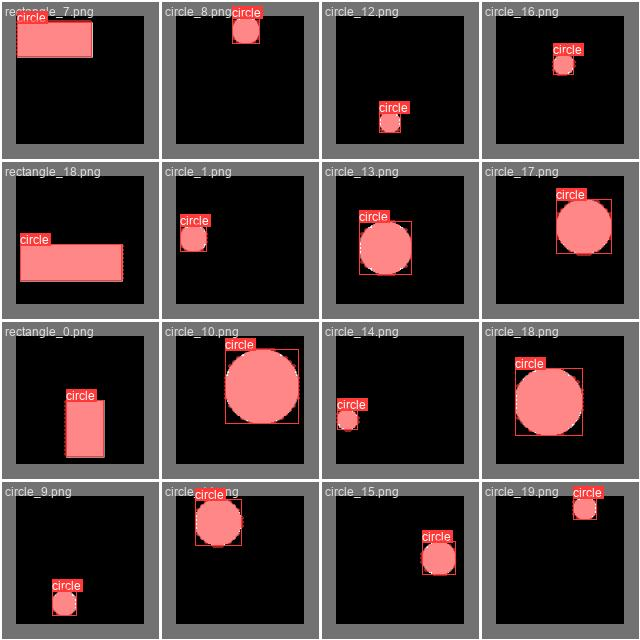

In [18]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train/val_batch1_labels.jpg")

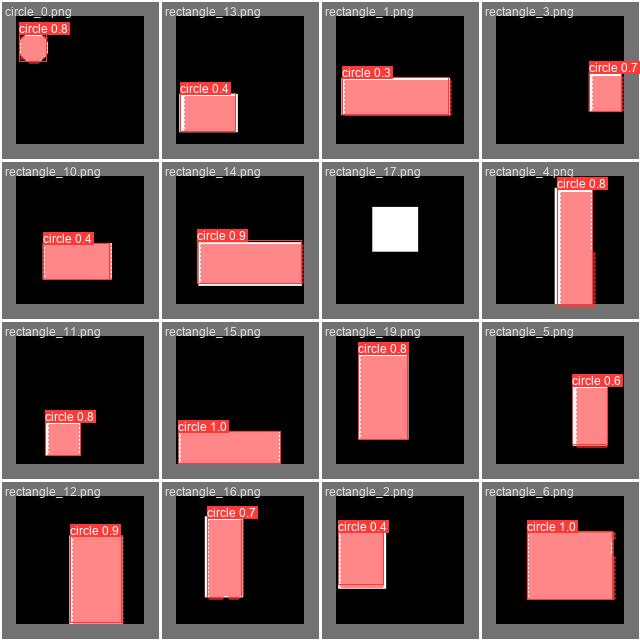

In [19]:
show_image(filename="runs/segment/train/val_batch0_pred.jpg")

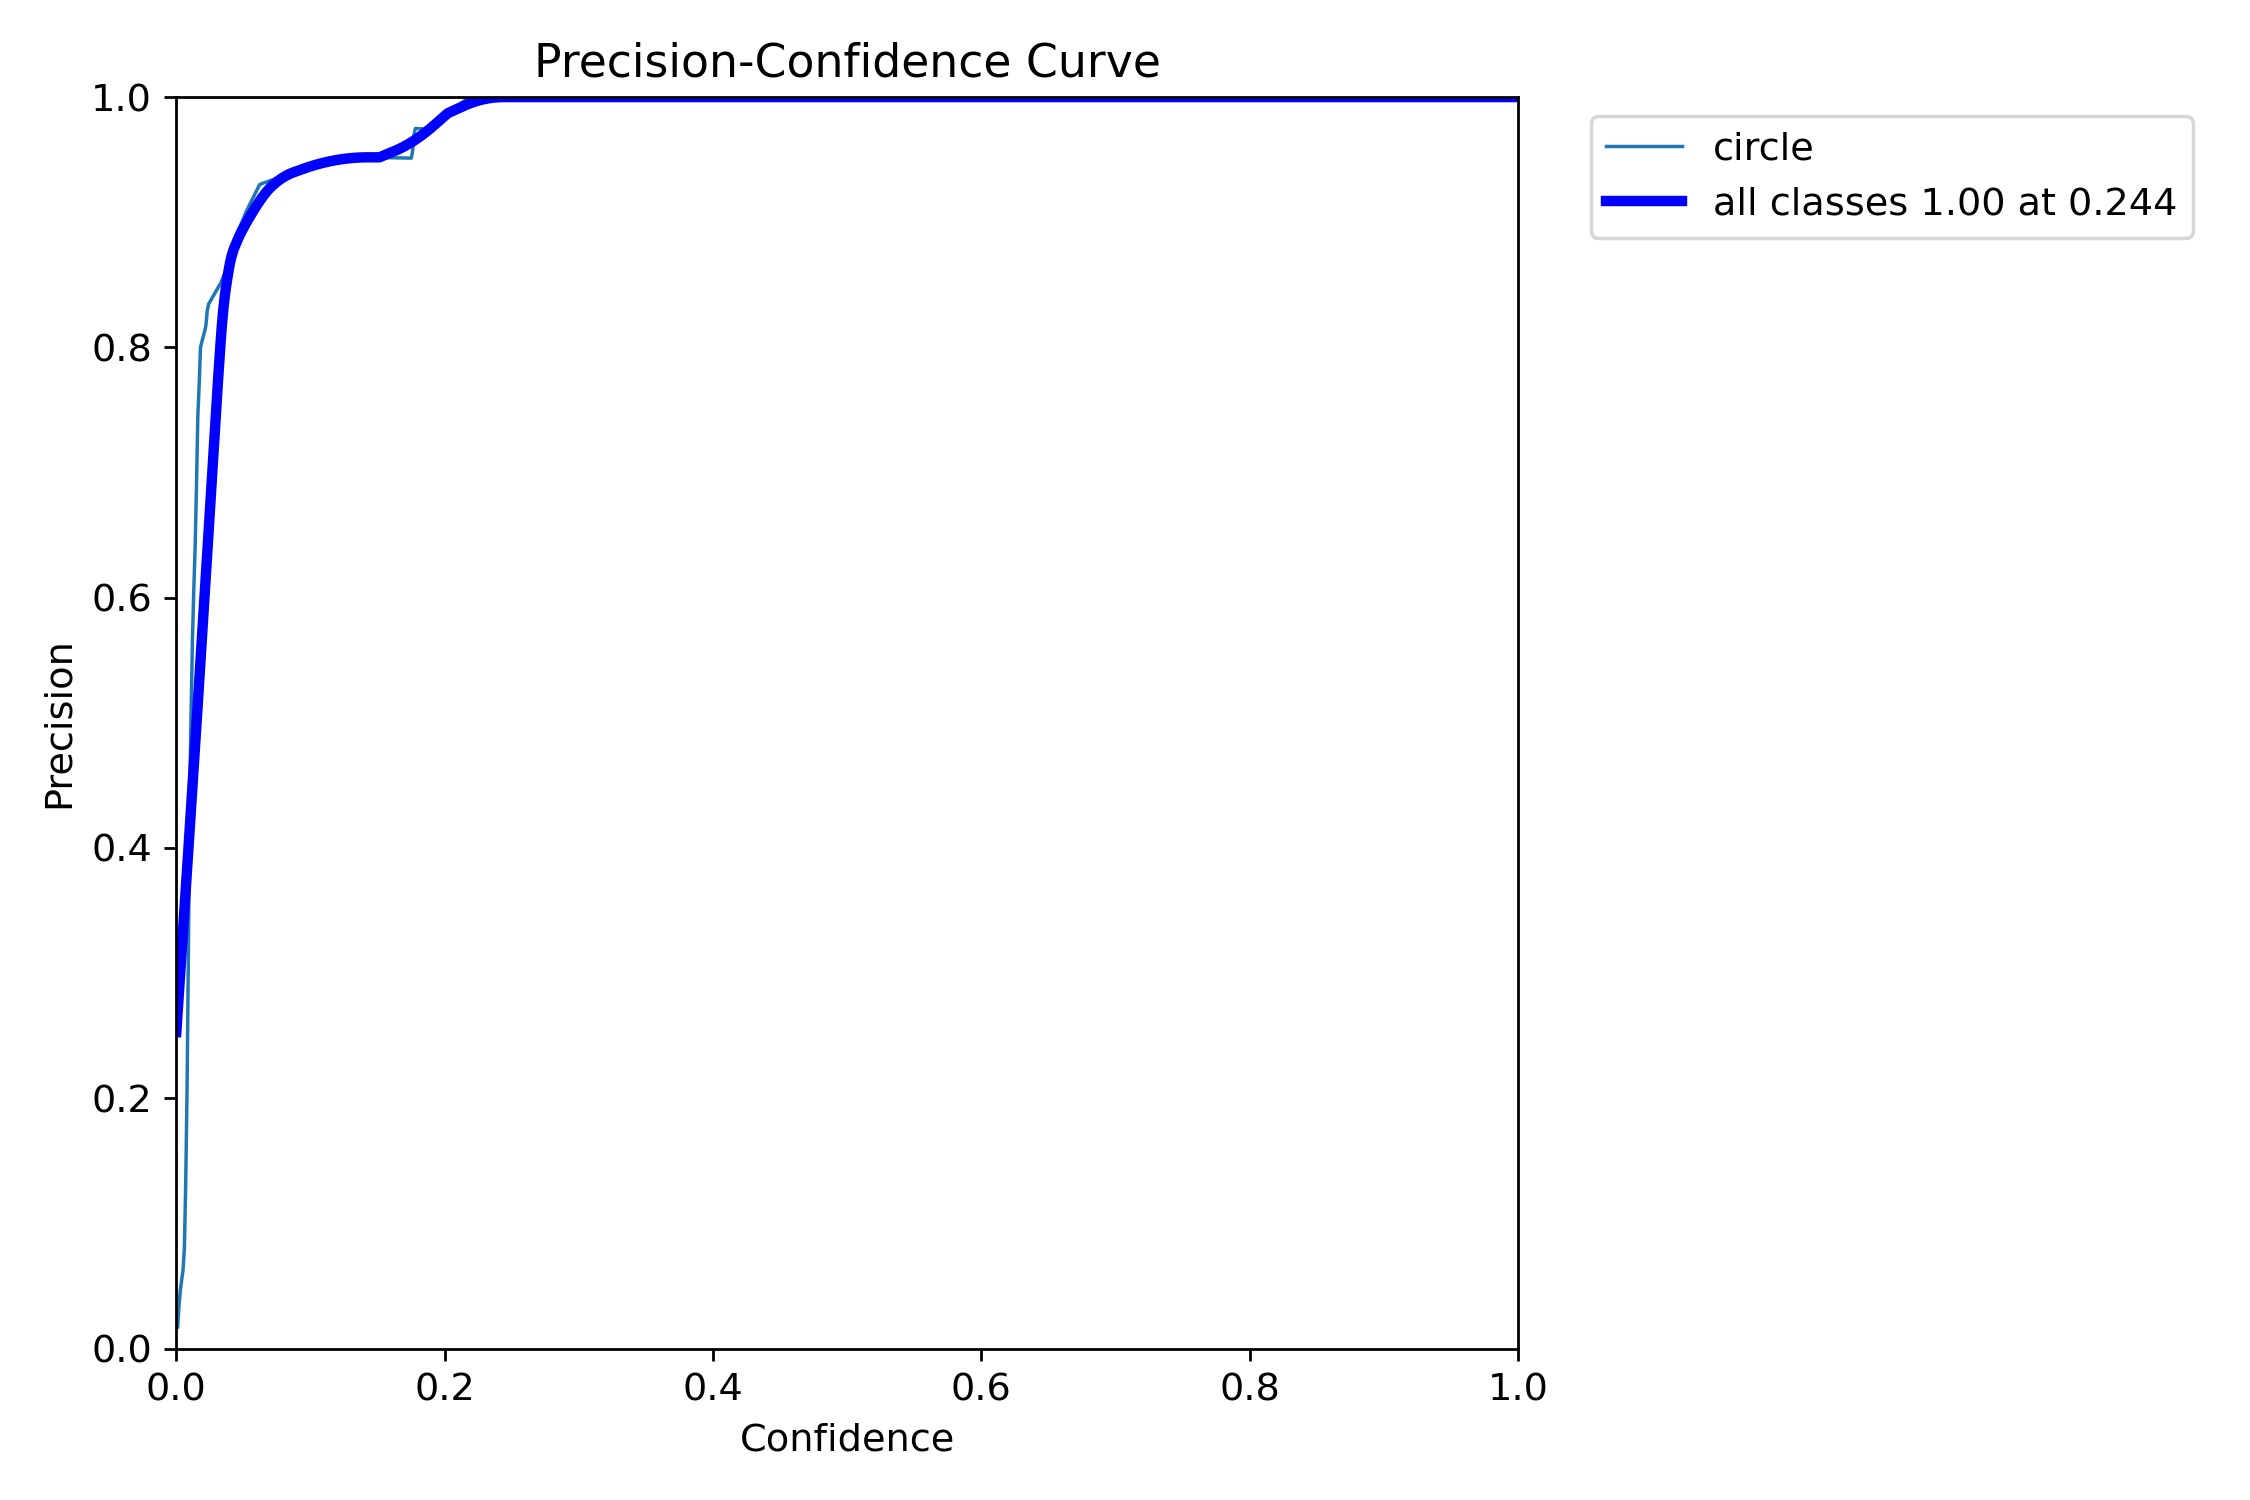

In [20]:
show_image(filename="runs/segment/train/MaskP_curve.png")

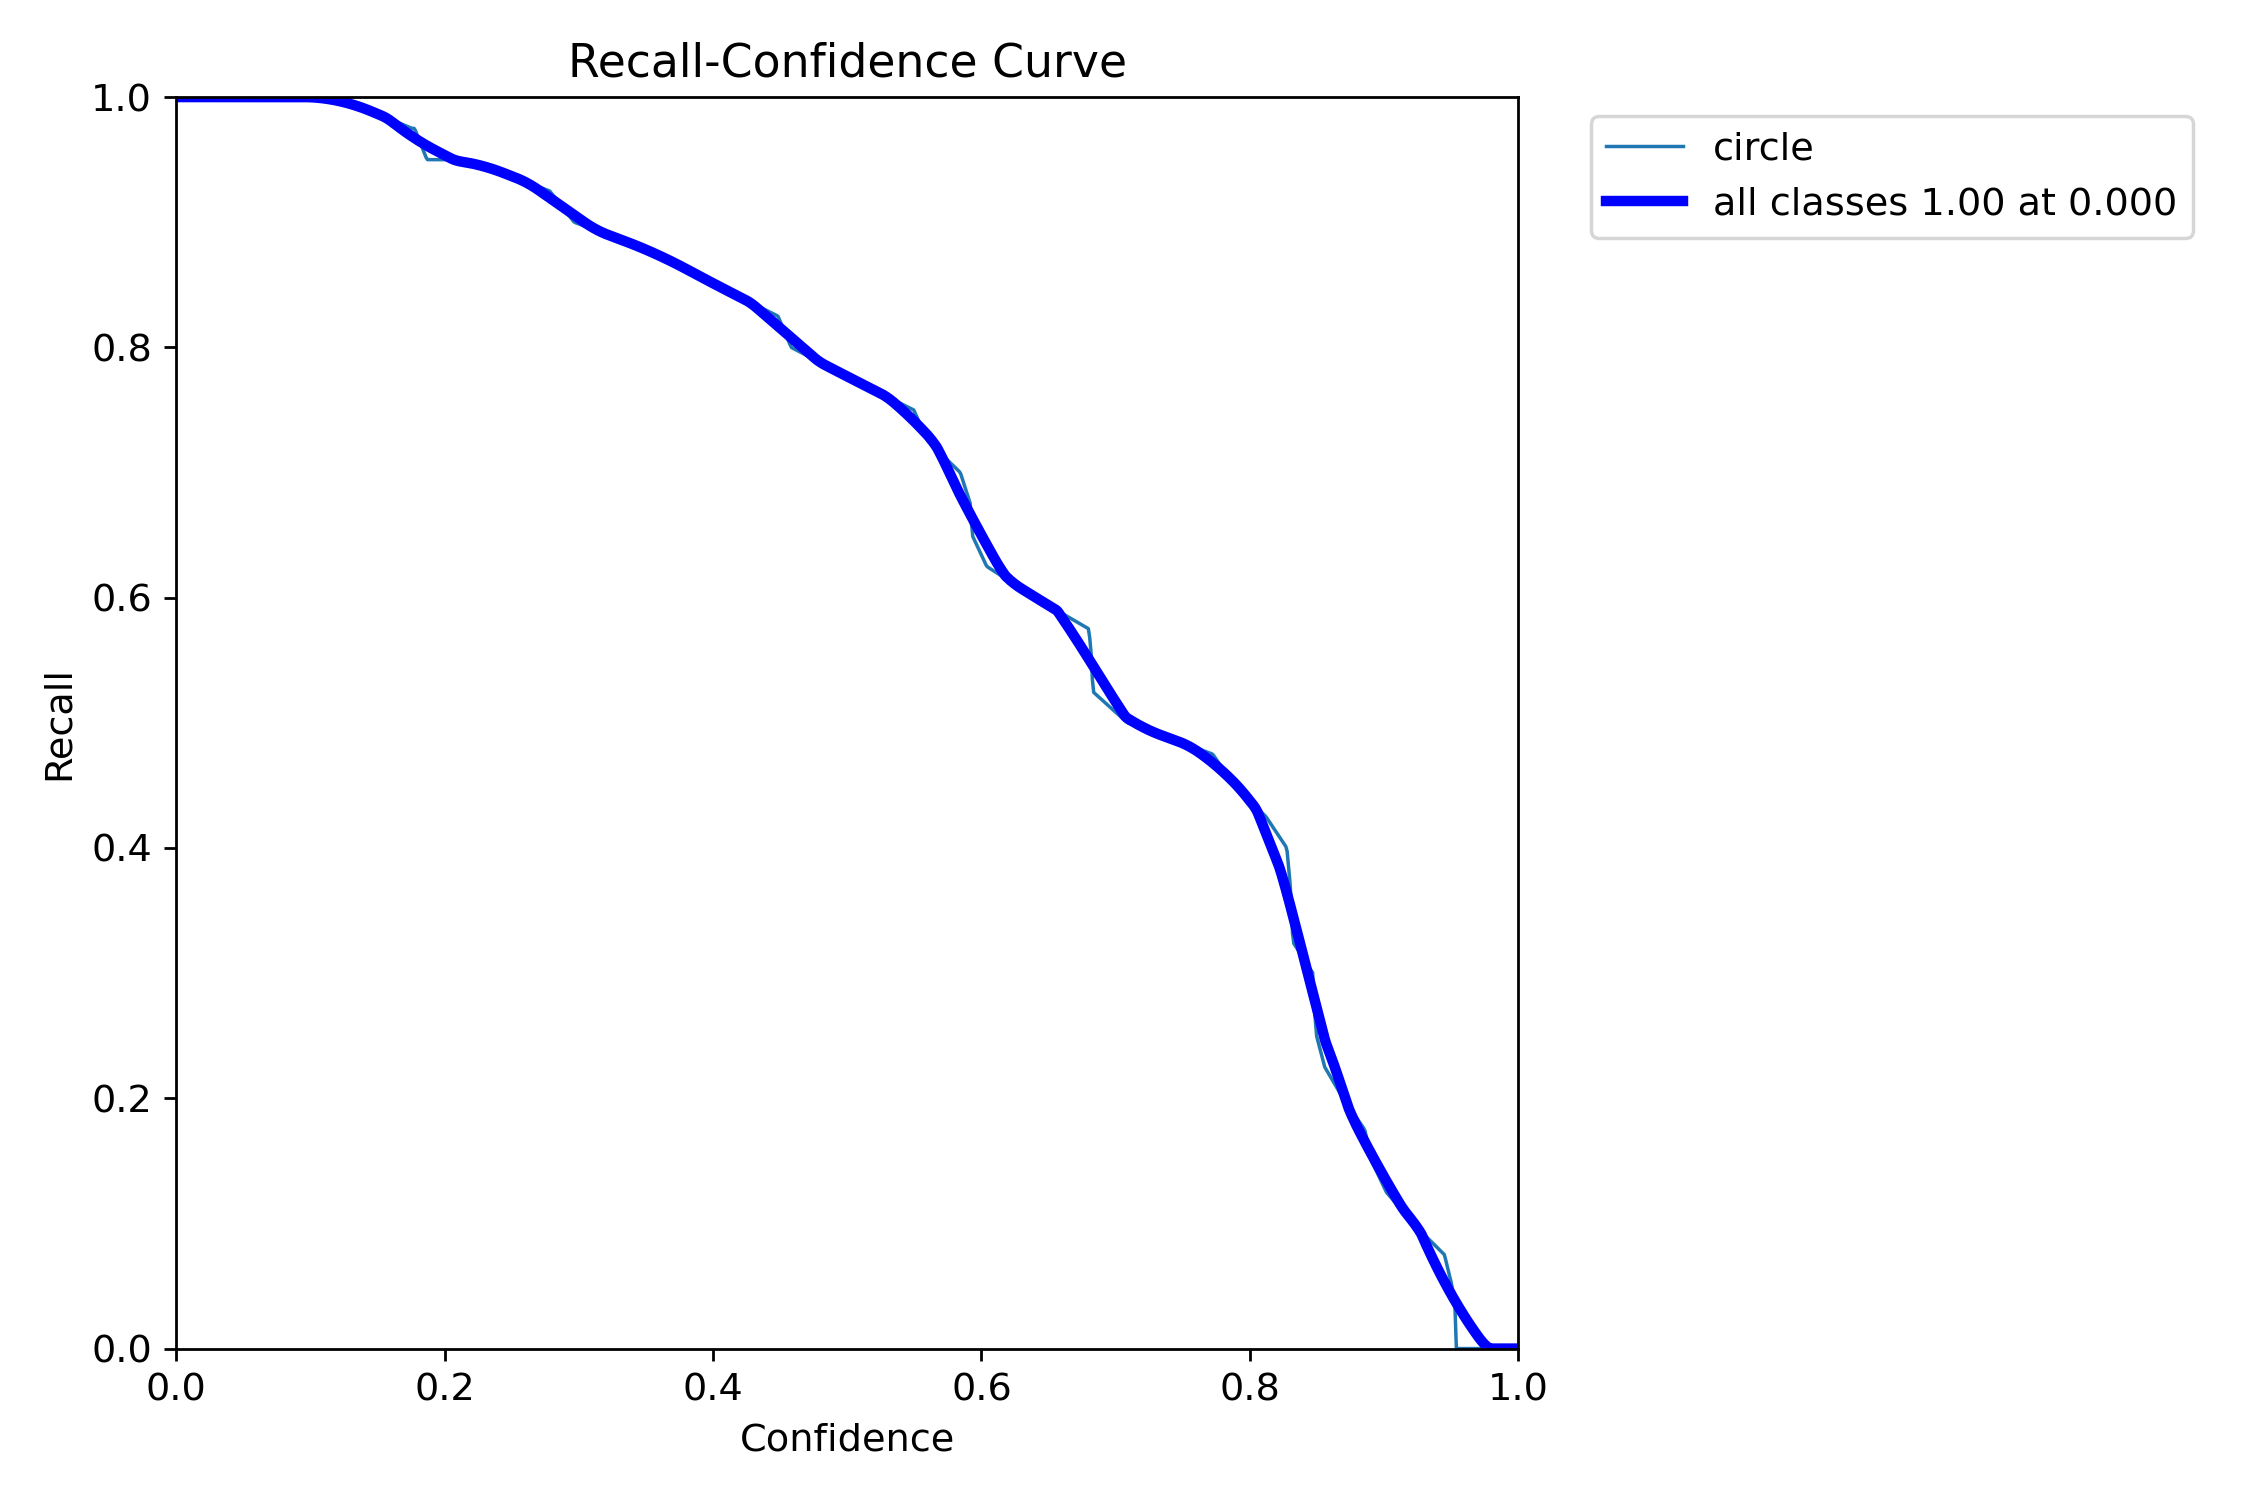

In [21]:
show_image(filename="runs/segment/train/MaskR_curve.png")

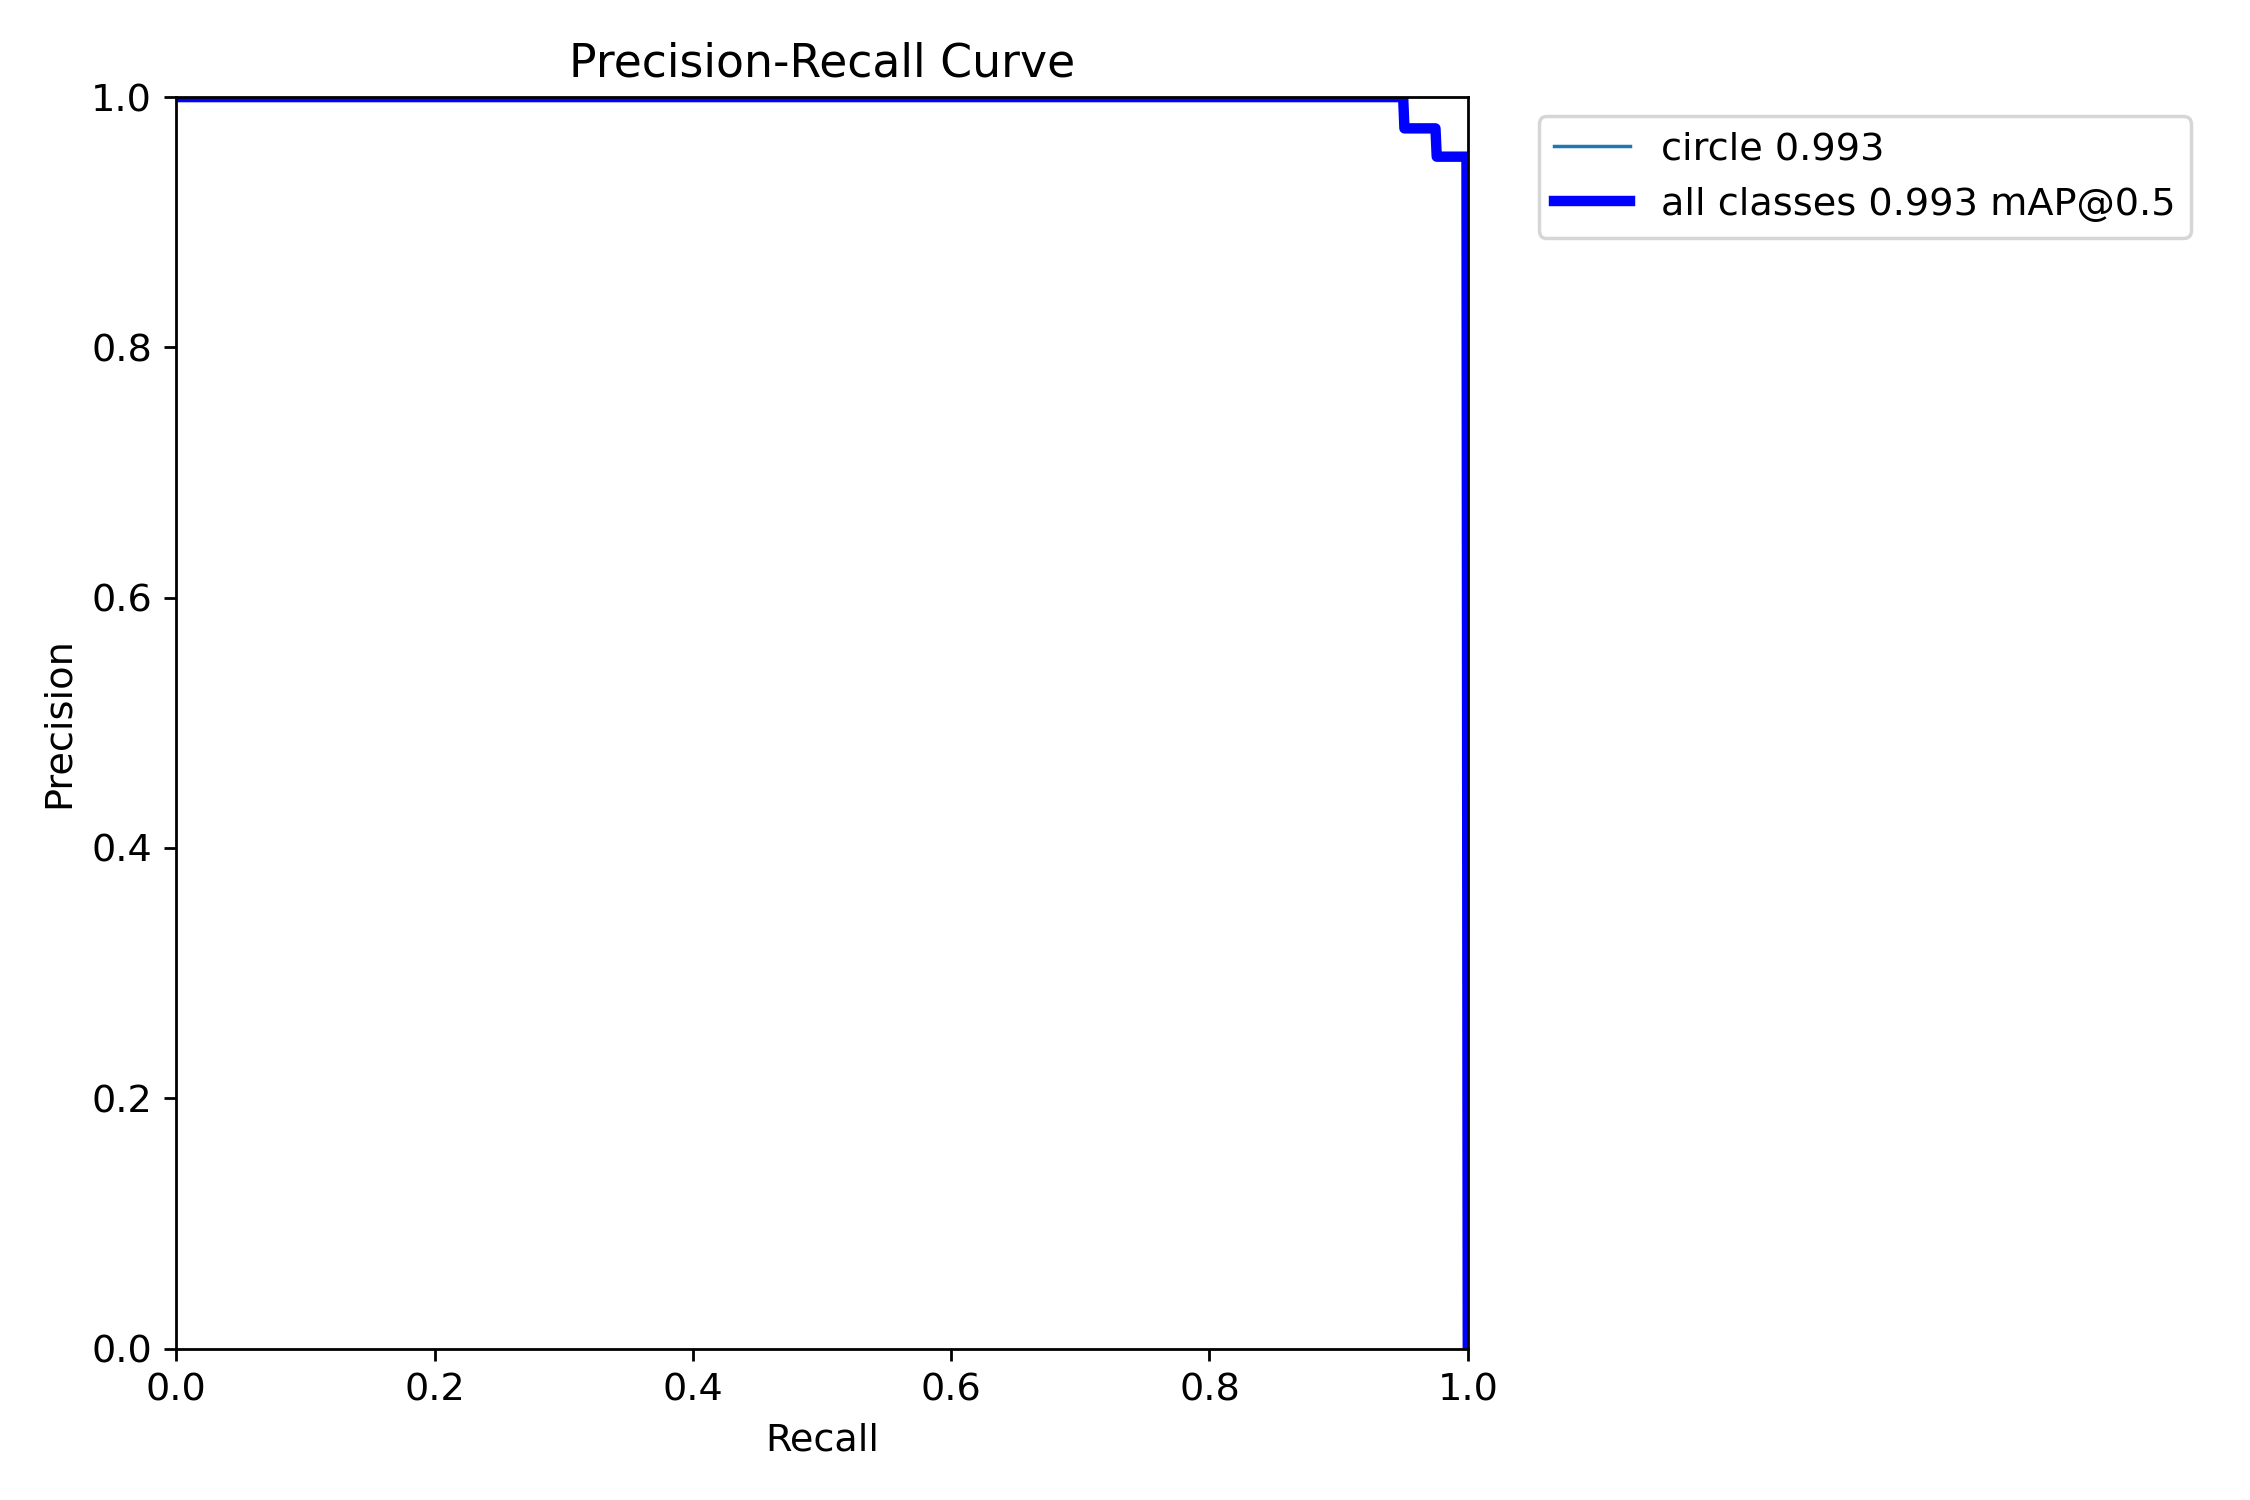

In [22]:
show_image(filename="runs/segment/train/MaskPR_curve.png")

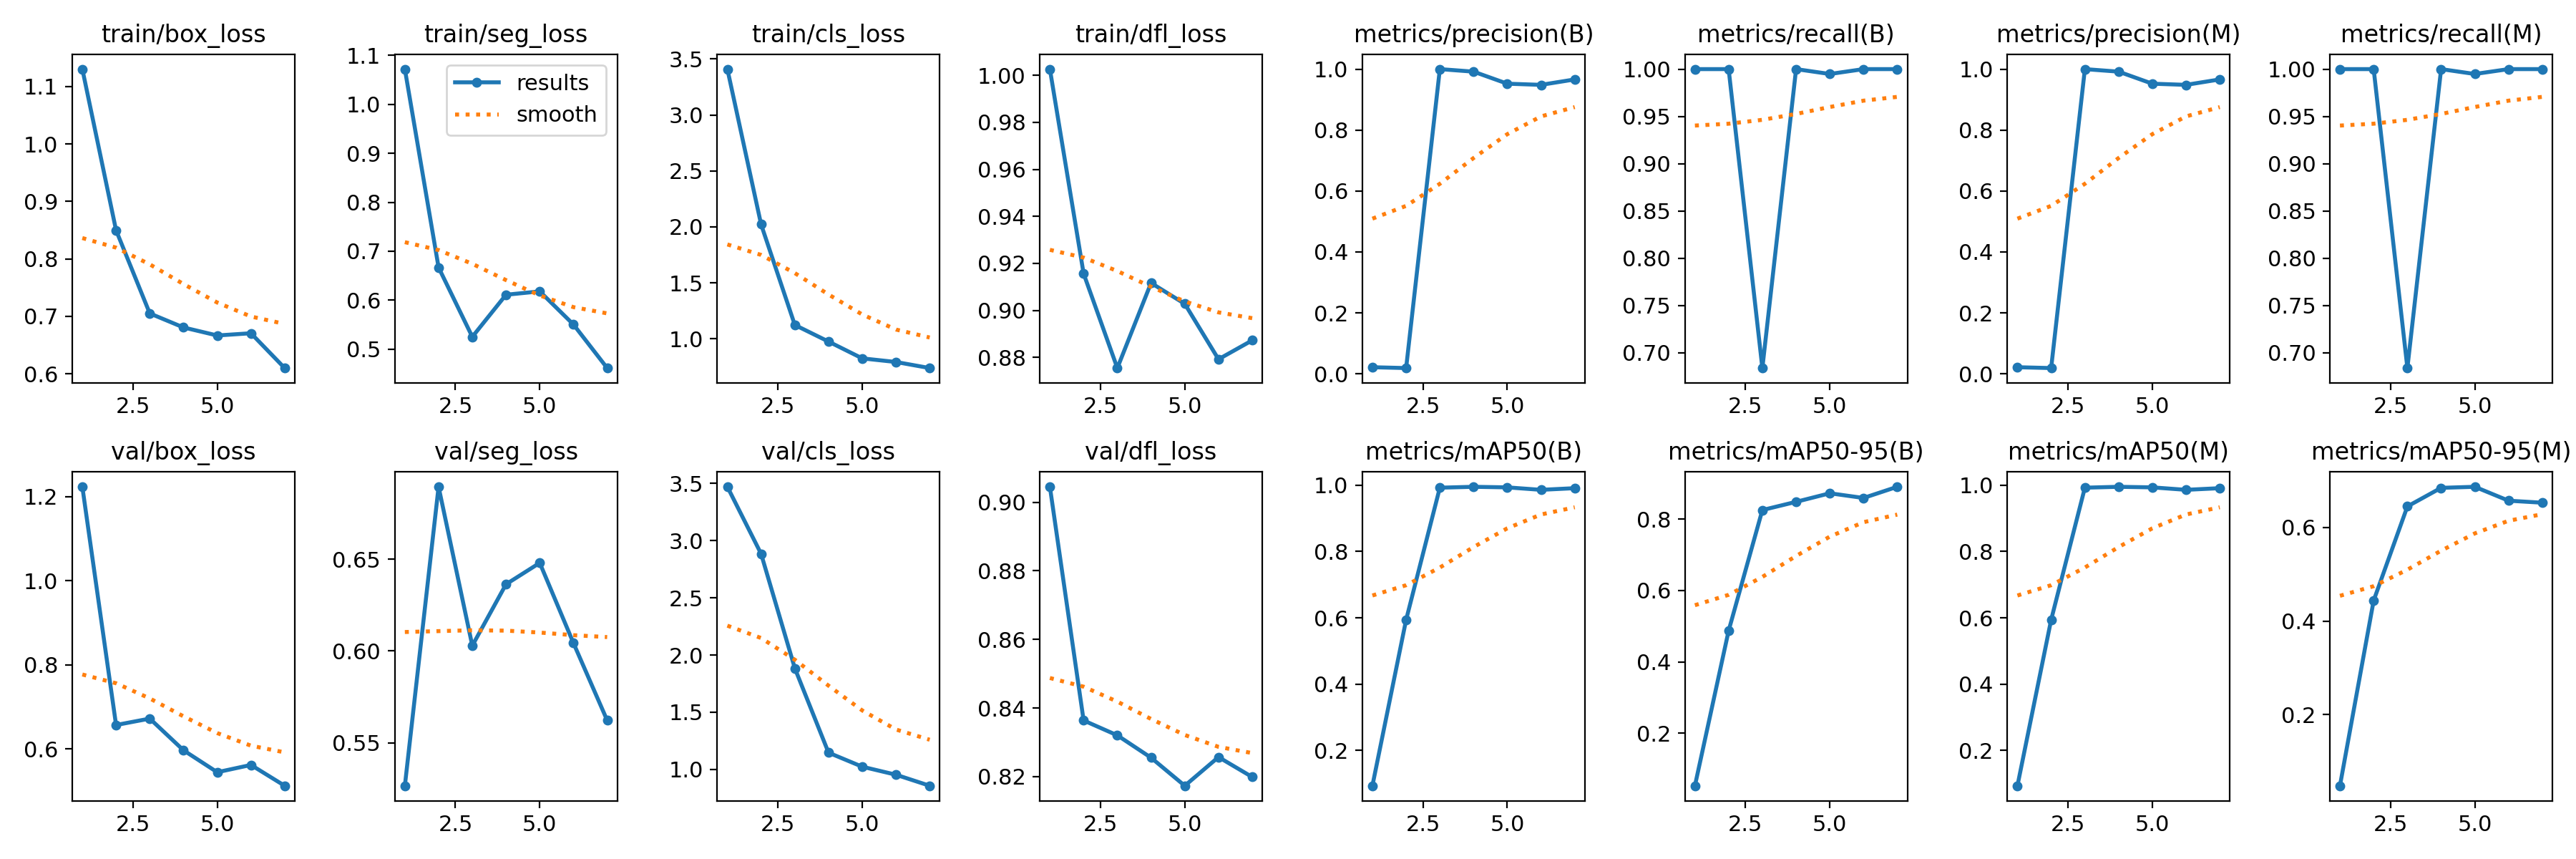

In [23]:
show_image(filename="runs/segment/train/results.png")

In [34]:
# Load the model
my_model = YOLO('runs/segment/train/weights/best.pt')

# Perform prediction on the circle image
results = list(my_model('datasets/test/images/circle_0.png', conf=0.128))
result = results[0]

# Get the boundary polygon of the object
masks_xy = result.masks.xyn
print("Mask information (pixel coordinates)：", masks_xy)

# Get the mask data
masks_data = result.masks.data
print("Mask data:", masks_data)

# Convert the mask data to a PIL image and display
import torchvision.transforms as T
T.ToPILImage()(result.masks.data).show()

# Display the original image
original_image = Image.open("datasets/test/images/circle_0.png")
original_image.show()



image 1/1 e:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\test\images\circle_0.png: 128x128 1 circle, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)
Mask information (pixel coordinates)： [array([[    0.40625,     0.34375],
       [    0.39844,     0.35156],
       [    0.39062,     0.35156],
       [    0.38281,     0.35937],
       [      0.375,     0.35937],
       [    0.36719,     0.36719],
       [    0.35937,     0.36719],
       [    0.35156,       0.375],
       [    0.34375,       0.375],
       [     0.3125,     0.40625],
       [     0.3125,     0.41406],
       [    0.28906,      0.4375],
       [    0.28125,      0.4375],
       [    0.27344,     0.44531],
       [    0.27344,     0.45312],
       [       0.25,     0.47656],
       [       0.25,     0.77344],
       [    0.25781,     0.78125],
       [    0.25781,     0.79687],
       [    0.26562,     0.79687],
       [    0.27344,     0.8046

In [36]:
# Load the model
my_model = YOLO('runs/segment/train/weights/best.pt')

# Use the model to predict the boundary polygon and mask information of the rectangle image
results = list(my_model('datasets/test/images/rectangle_3.png', conf=0.128))
result = results[0]

# Get the coordinate information of the boundary polygon
masks_xy = result.masks.xyn
print("Mask information (pixel coordinates)：", masks_xy)

# Get the mask data
masks_data = result.masks.data
print("Mask data:", masks_data)

# Convert the mask data to PIL image and display
import torchvision.transforms as T
T.ToPILImage()(result.masks.data).show()

# Display the original image
original_image = Image.open("datasets/test/images/rectangle_3.png")
original_image.show()


image 1/1 e:\硕士文件\TUE\tue-5ARIP10-Q3 Team project\YOLO\ultralytics-main\datasets\test\images\rectangle_3.png: 128x128 1 circle, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)
Mask information (pixel coordinates)： [array([[    0.28906,       0.125],
       [    0.28125,     0.13281],
       [    0.28125,     0.35937],
       [    0.28906,     0.36719],
       [    0.86719,     0.36719],
       [      0.875,     0.35937],
       [    0.88281,     0.35937],
       [    0.89062,     0.35156],
       [    0.89062,     0.33594],
       [    0.89844,     0.32812],
       [    0.89844,     0.13281],
       [    0.89062,       0.125]], dtype=float32)]
Mask data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
